In [5]:
import numpy as np
import pandas as pd
import sys
#from utils import score
sys.path.pop(0)
from RealData.EpsGreedy import epsilon_greedy_policy, run_epsilon_policy
from RealData.RegretBalancing import RunRegretBalancingEpsilonGreedy
from RealData.LoadData import create_dataframe
from RealData.UCB import run_UCB_policy
""" 
from RealData. import 
from RealData. import 
from RealData. import 
from RealData. import 
#from RealData. import 
"""
from tqdm import tqdm
import matplotlib.pyplot as plt
import argparse
from numpy.linalg import norm, pinv
np.random.seed(2025)

# Load the Data

In [2]:
df = create_dataframe()

reading movielens 20m data
preparing ratings log


In [4]:
df.head()

,userId,movieId,rating,timestamp,movieId_movie,title,(no genres listed),Action,Adventure,Animation,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,t,liked
t,,,,,,,,,,,,,,,,,,,,,
0,6115,59315,3.0,1520579909,200584.0,Krakatit (1948),False,False,False,False,...,False,False,False,False,True,True,False,False,0,0
1,113098,4993,5.0,1361814588,5099.0,Heidi (1937),False,False,False,False,...,False,False,False,False,False,False,False,False,1,1
2,94880,1208,5.0,1237134870,1241.0,Dead Alive (Braindead) (1992),False,False,False,False,...,False,False,False,False,False,False,False,False,2,1
3,154436,110,4.0,976335996,112.0,Rumble in the Bronx (Hont faan kui) (1995),False,True,True,False,...,False,False,False,False,False,False,False,False,3,0
4,34128,7361,3.5,1352638303,7573.0,Never Say Never Again (1983),False,True,True,False,...,False,False,False,False,False,True,False,False,4,0


# Run experiments

## EpsilonGreedy Policy

### Fixed $ \epsilon $

#### Experience 1

/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_7813/3290611247.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, actions])


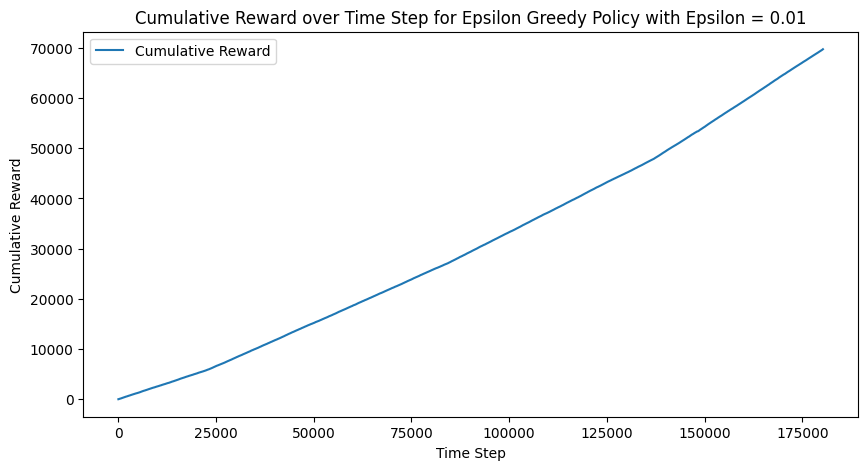

In [37]:
history = pd.DataFrame(data=None, columns=df.columns)
history = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards, history = run_epsilon_policy(df, history, epsilon = .01, slate_size = 5, batch_size = 10000, verbose = False, plot = True)

#### Experience 2

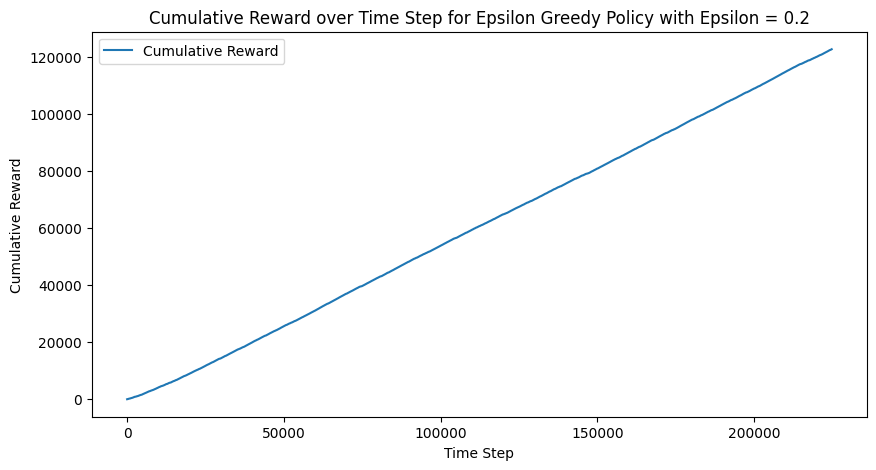

In [39]:
history2 = pd.DataFrame(data=None, columns=df.columns)
history2 = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards2, history2 = run_epsilon_policy(df, history, epsilon = .2, slate_size = 5, batch_size = 10000, verbose = False, plot = True)

#### Experience 3

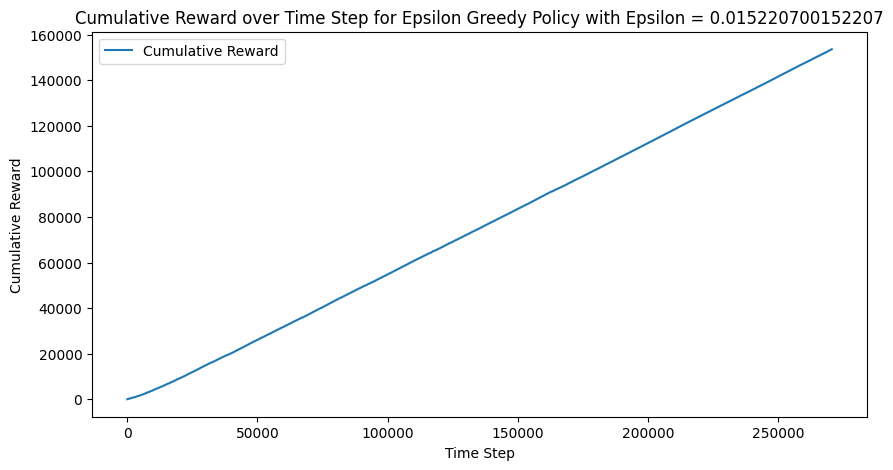

In [40]:
history3 = pd.DataFrame(data=None, columns=df.columns)
history3 = history.astype({'movieId': 'int32', 'liked': 'float'})
rewards3, history3 = run_epsilon_policy(df, history, epsilon = 1e5, slate_size = 5, batch_size = 10000, verbose = False, plot = True, fixed_epsilon=False)

#### Comparison

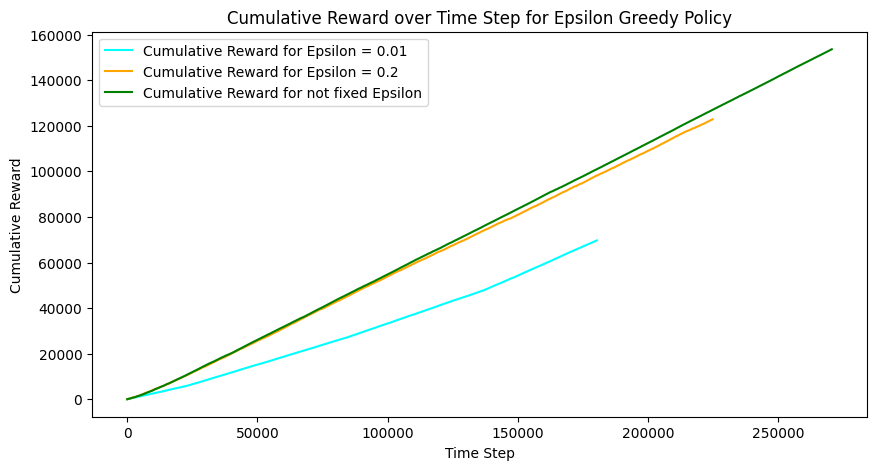

In [45]:
plt.figure(figsize = (10, 5))
plt.plot(np.cumsum(rewards), label = 'Cumulative Reward for Epsilon = 0.01', color = 'cyan')
plt.plot(np.cumsum(rewards2), label = 'Cumulative Reward for Epsilon = 0.2', color = 'orange')
plt.plot(np.cumsum(rewards3), label = 'Cumulative Reward for not fixed Epsilon', color = 'green')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time Step for Epsilon Greedy Policy')
plt.legend()
plt.show()

### Regret Balancing for EpsilonGreedy agents

In [70]:
def RunRegretBalancingEpsilonGreedy(df, history, learners=[0.5, 0.01, 0.001], slate_size=5, batch_size=10000, verbose=False, plot=True):
    history_init = history.copy()
    history_init_RB = history.copy()
    arms = df.movieId.unique()
    K = len(arms)
    R = np.zeros(len(learners))
    N = np.ones(len(learners))
    G = np.zeros(len(learners))
    t = 0
    rewards = []
    max_time = df.shape[0]
    

    # Iterate over batches
    for step in tqdm(range(max_time // batch_size)):
        t = step * batch_size
        u_bound = lambda x: np.sqrt(K * t)

        # Print progress if verbose is enabled
        if verbose and t % 100000 == 0:
            print(f"Processing step {t}...")

        set_to_maximize_index = [(R[i] / N[i]) + (u_bound(t) / N[i]) for i in range(len(learners))]
        j_t = np.argmax(set_to_maximize_index)
        b_t = set_to_maximize_index[j_t]
        # Empirical regret of base i at round t:

        G = N * b_t - R
        i_t = np.argmin(G)
        
        recs = epsilon_greedy_policy(df=history_init_RB.loc[history_init_RB.t<=t,], arms=df.movieId.unique(), epsilon=learners[i_t], slate_size=slate_size, batch_size=batch_size)
        N[i_t] += 1
        # Score the recommendations and update history
        history_init_RB, action_score = score(history_init_RB, df, t, batch_size, recs)
        # Accumulate rewards from action scores
        if action_score is not None:
            Rs = action_score.liked.tolist()
            rewards.extend(Rs)
            R[i_t] += np.sum(Rs)
        
    if plot:
        plt.figure(figsize = (10, 5))
        plt.plot(np.cumsum(rewards), label = 'Cumulative Reward of Regret Balancing')
        for epsilon in tqdm(learners):
            history_init_epsilon = history_init.copy()
            rewards_epsilon, history_epsilon = run_epsilon_policy(df, history_init_epsilon, epsilon = epsilon, slate_size = 5, batch_size = batch_size, verbose = False, plot = False, fixed_epsilon=False)
            plt.plot(np.cumsum(rewards_epsilon), label = 'Cumulative Reward of Epsilon Greedy with Epsilon = {}'.format(epsilon))  
        plt.xlabel('Time Step')
        plt.ylabel('Cumulative Reward')
        plt.title('Cumulative Reward over Time Step for Regret Balancing')
        plt.legend()
        plt.show()
    return rewards, history_init_RB

  0%|          | 0/658 [00:00<?, ?it/s]/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_7813/1201940607.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, actions])
  0%|          | 0/3 [00:00<?, ?it/s]/Users/augustincablant/Documents/GitHub/Advanced-ML/src/RealData/EpsGreedy.py:182: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  
 33%|███▎      | 1/3 [00:21<00:43, 21.68s/it]/Users/augustincablant/Documents/GitHub/Advanced-ML/src/RealData/EpsGreedy.py:18

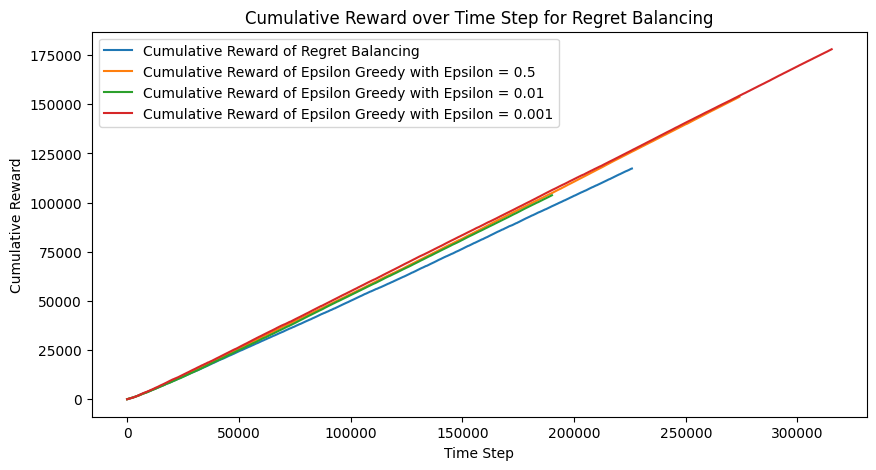

In [71]:
history4 = pd.DataFrame(data=None, columns=df.columns)
history4 = history4.astype({'movieId': 'int32', 'liked': 'float'})
rewards4, history4 = RunRegretBalancingEpsilonGreedy(df, history4, slate_size = 5, batch_size = 10000, verbose = False, plot = True)

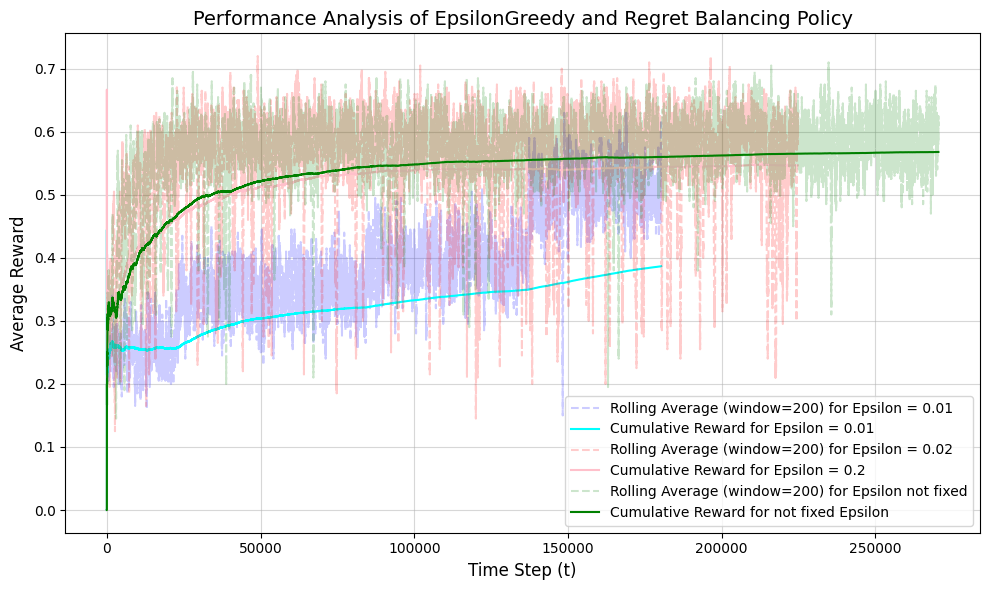

In [44]:
cumulative_avg1 = np.cumsum(rewards) / np.linspace(1, len(rewards), len(rewards))
cumulative_avg2 = np.cumsum(rewards2) / np.linspace(1, len(rewards2), len(rewards2))
cumulative_avg3 = np.cumsum(rewards3) / np.linspace(1, len(rewards3), len(rewards3))
#cumulative_avg4 = np.cumsum(rewards4) / np.linspace(1, len(rewards), len(rewards))

plt.figure(figsize=(10, 6)) 
plt.plot(pd.Series(rewards).rolling(200).mean(), label='Rolling Average (window=200) for Epsilon = 0.01', color='blue', linestyle='--', alpha = 0.2)
plt.plot(cumulative_avg1, label='Cumulative Reward for Epsilon = 0.01', color='cyan', linestyle='-')
plt.plot(pd.Series(rewards2).rolling(200).mean(), label='Rolling Average (window=200) for Epsilon = 0.02', color='red', linestyle='--', alpha = 0.2)
plt.plot(cumulative_avg2, label = 'Cumulative Reward for Epsilon = 0.2', color = 'pink')
plt.plot(pd.Series(rewards3).rolling(200).mean(), label='Rolling Average (window=200) for Epsilon not fixed', color='green', linestyle='--', alpha = 0.2)
plt.plot(cumulative_avg3, label = 'Cumulative Reward for not fixed Epsilon', color = 'green')
#plt.plot(cumulative_avg4, label = 'Cumulative Reward for Regret Balancing', color = 'red')
plt.title('Performance Analysis of EpsilonGreedy and Regret Balancing Policy', fontsize=14)
plt.xlabel('Time Step (t)', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5) 
plt.tight_layout()
plt.show()

## UCB

In [30]:
def ucb_policy(df, t, slate_size=5, batch_size=50, ucb_scale=2.0):
    """
    Applies the Upper Confidence Bound (UCB) policy to generate movie recommendations.

    The UCB policy is a popular method in multi-armed bandit problems. It balances exploration 
    (trying underexplored options) and exploitation (choosing options with the highest observed rewards) 
    by assigning a confidence bound to each action. This confidence bound increases with uncertainty 
    about an action's mean reward and decreases as more information about the action is gathered.

    Args:
        df (pd.DataFrame): A DataFrame containing the historical data of movie interactions.
            Must include the following columns:
                - 'movieId' (int or str): The identifier of each movie (arm).
                - 'liked' (float or int): The reward signal, e.g., whether the movie was liked.
        t (int): The current time step, used to calculate the exploration term. It should be 
            greater than 0 and represent the number of rounds or batches processed so far.
        slate_size (int, optional): The number of recommendations to generate in each step. 
            Defaults to 5.
        batch_size (int, optional): The number of users served recommendations in each batch. 
            This parameter is not directly used in the function but can influence how 
            `t` is defined in the context of the broader system. Defaults to 50.
        ucb_scale (float, optional): A scaling factor for the exploration term. Most implementations 
            use a value of 2.0, but it can be adjusted to control the balance between exploration 
            and exploitation. Defaults to 2.0.

    Returns:
        recs (np.ndarray): A NumPy array containing the `movieId`s of the recommended movies, 
        ordered by their UCB scores in descending order.

    Notes:
        - The UCB score is computed as:
            UCB = mean_reward + sqrt((ucb_scale * log10(t)) / count)
          where:
            - `mean_reward` is the average reward for each movie.
            - `log10(t)` encourages exploration for movies with fewer interactions.
            - `count` is the number of times a movie has been selected.
        - Movies with no interactions (count = 0) should be handled in the calling logic if 
          they are part of the dataset but not included in the `df` used by this function.
    """
    # Calculate mean, count, and standard deviation of rewards for each movie
    scores = df[['movieId', 'liked']].groupby('movieId').agg({'liked': ['mean', 'count', 'std']})
    scores.columns = ['mean', 'count', 'std']

    # Compute UCB scores
    scores['ucb'] = scores['mean'] + np.sqrt(
        (ucb_scale * np.log10(t)) / (scores['count'] + 1e-6))
    
    # Extract top recommendations based on UCB scores
    scores['movieId'] = scores.index
    scores = scores.sort_values('ucb', ascending=False)
    recs = scores.loc[scores.index[0:slate_size], 'movieId'].values
    return recs

def run_UCB_policy(df, history, slate_size=5, batch_size=50, ucb_scale=2.0, verbose=False, plot=False):
    """
    """
    # Initialize variables
    rewards = []
    max_time = df.shape[0]  # Total number of time steps (ratings) to evaluate

    # Iterate over batches
    for step in range(max_time // batch_size):
        t = step * batch_size

        # Print progress if verbose is enabled
        if verbose and t % 100000 == 0:
            print(f"Processing step {t}...")

        # Choose arms (recommendations) using epsilon-greedy policy
        recs = ucb_policy(df=history.loc[history.t<=t,], t = t/batch_size, ucb_scale=ucb_scale)

        # Score the recommendations and update history
        history, action_score = score(history, df, t, batch_size, recs)

        # Accumulate rewards from action scores
        if action_score is not None:
            action_score = action_score.liked.tolist()
            rewards.extend(action_score)
    if plot:
        plt.figure(figsize = (10, 5))
        plt.plot(np.cumsum(rewards), label = 'Cumulative Reward')
        plt.xlabel('Time Step')
        plt.ylabel('Cumulative Reward')
        plt.title('Cumulative Reward over Time Step for UCB Policy')
        plt.legend()
        plt.show()
    return rewards, history

Processing step 0...


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_7813/3611534206.py:46: RuntimeWarning: divide by zero encountered in log10
  (ucb_scale * np.log10(t)) / (scores['count'] + 1e-6))
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


Processing step 100000...
Processing step 200000...
Processing step 300000...
Processing step 400000...
Processing step 500000...
Processing step 600000...
Processing step 700000...
Processing step 800000...
Processing step 900000...
Processing step 1000000...
Processing step 1100000...
Processing step 1200000...
Processing step 1300000...
Processing step 1400000...
Processing step 1500000...
Processing step 1600000...
Processing step 1700000...
Processing step 1800000...
Processing step 1900000...
Processing step 2000000...
Processing step 2100000...
Processing step 2200000...
Processing step 2300000...
Processing step 2400000...
Processing step 2500000...
Processing step 2600000...
Processing step 2700000...
Processing step 2800000...
Processing step 2900000...
Processing step 3000000...
Processing step 3100000...
Processing step 3200000...
Processing step 3300000...
Processing step 3400000...
Processing step 3500000...
Processing step 3600000...
Processing step 3700000...
Processing

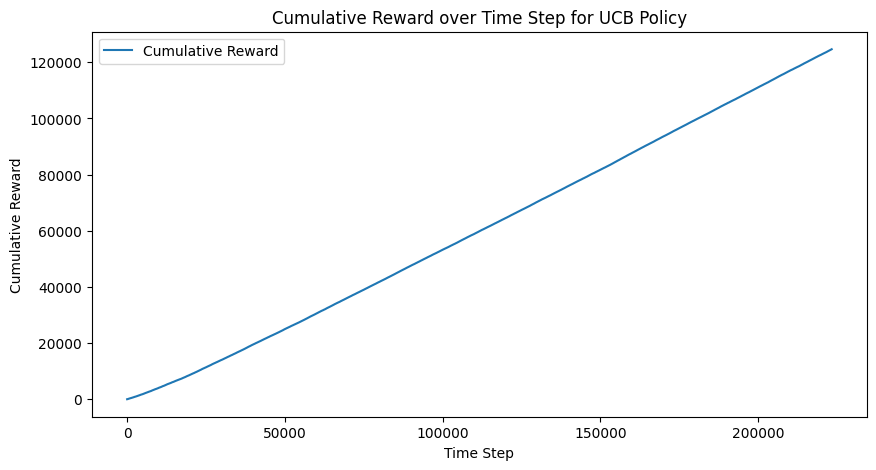

In [31]:
history = df.groupby('movieId').first()
history['movieId'] = history.index
history['t'] = 0
history.index = history['t']
history['liked'] = 1
history = history[df.columns] # reorder columns to match logged data
history2 = history.copy()
history2['liked'] = 0
history = pd.concat([history, history, history2, history2, history])
history['scoring_round'] = 0
rewards5, history5 = run_UCB_policy(df, history, slate_size=5, batch_size=10000, ucb_scale=2.0, verbose=True, plot=True)

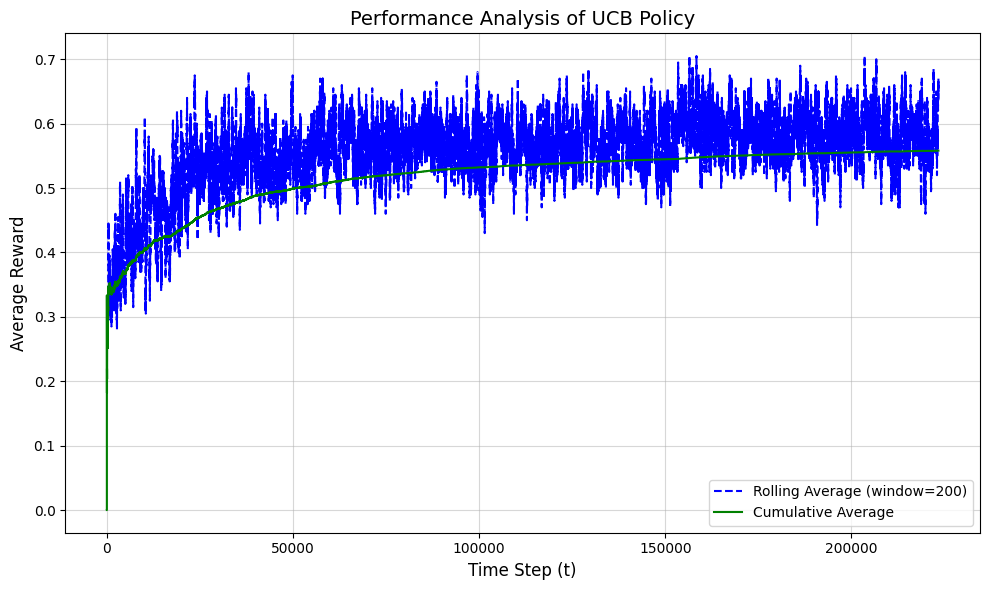

In [34]:
cumulative_avg = np.cumsum(rewards5) / np.linspace(1, len(rewards5), len(rewards5))

plt.figure(figsize=(10, 6)) 
plt.plot(pd.Series(rewards5).rolling(200).mean(), label='Rolling Average (window=200)', color='blue', linestyle='--')
plt.plot(cumulative_avg, label='Cumulative Average', color='green', linestyle='-')
plt.title('Performance Analysis of UCB Policy', fontsize=14)
plt.xlabel('Time Step (t)', fontsize=12)
plt.ylabel('Average Reward', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5) 
plt.tight_layout()
plt.show()

In [35]:
plt.figure(figsize = (10, 5))
plt.plot(np.cumsum(rewards), label = 'Cumulative Reward for Epsilon = 0.01', color = 'cyan')
plt.plot(np.cumsum(rewards2), label = 'Cumulative Reward for Epsilon = 0.2', color = 'orange')
plt.plot(np.cumsum(rewards3), label = 'Cumulative Reward for not fixed Epsilon', color = 'green')
plt.plot(np.cumsum(rewards5), label = 'Cumulative Reward for UCB', color = 'purple')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Time Step for Epsilon Greedy and UCB Policy')
plt.legend()
plt.show()

NameError: name 'rewards' is not defined

<Figure size 1000x500 with 0 Axes>